# Energy Demand Modeling - LTSM RNN

In this notebook, we will attempt to implement a simple univariate Long short-Term Memory Network (LSTM) model utilizing Keras. LTSMs are a variety of recurring neural networks (RNN) that are capable of learning long-term dependencies, especially in sequence prediction problems. 

Utilizing CENACE demand  data, we will generate a model that predicts the next 24 hours of demand using the last 24 hours of demand. It thus considers 24 individuals forecast corresponding to each hour of each day.

In [114]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from datetime import datetime, timedelta

import keras
import tensorflow

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Let's load in the .csv we built in our EDA notebook:

In [115]:
energy_df = pd.read_csv('./Modeling_DataFrames/price_gen_demand.csv')

In [116]:
energy_df.set_index('date_and_time', inplace=True)

In [117]:
energy_df.columns

Index(['load_zone', 'zone_price', 'wind_mwh', 'solar_mwh', 'biomass_mwh', 'carbon_mwh', 'combined_cycle_mwh', 'internal_combustion_mwh', 'geothermal_mwh', 'hydro_mwh', 'nuclear_mwh', 'conventional_thermal_mwh', 'natural_gas_mwh', 'NES_demand_mwh', 'NES_forecasted_demand_mwh', 'NES_MAPE'], dtype='object')

For this model, we're only going to consider Northeastern Energy Demand time series, so let's go ahead and select those two columns:

In [118]:
demand_df = energy_df[['NES_demand_mwh', 'NES_forecasted_demand_mwh']]

In [119]:
demand_df

NES_demand_mwh  NES_forecasted_demand_mwh
date_and_time                                                 
2019-01-01 00:00:00          3724.0                       3947
2019-01-01 01:00:00          3677.0                       3845
2019-01-01 02:00:00          3625.0                       3756
2019-01-01 03:00:00          3587.0                       3707
2019-01-01 04:00:00          3522.0                       3623
...                             ...                        ...
2022-12-31 19:00:00          4545.0                       4437
2022-12-31 20:00:00          4344.0                       4248
2022-12-31 21:00:00          4225.0                       4108
2022-12-31 22:00:00          4054.0                       4028
2022-12-31 23:00:00          3955.0                       3922

[35059 rows x 2 columns]

In [120]:
## We're covering 2019 through 2022, inclusive.
demand_df.index.min(), demand_df.index.max()

('2019-01-01 00:00:00', '2022-12-31 23:00:00')

In [121]:
# No null values, data is completely clean.
demand_df.isnull().sum()

NES_demand_mwh               0
NES_forecasted_demand_mwh    0
dtype: int64

## Transforming Data: Hourly Sequences

In order to better understand the relationship between energy demand at one hour and energy demand at another, we're going to reorganize our demand dataset. If the demand at hour four (h4) and the demand at hour six (h6) are somehow correlated, it helps to the price at a given hour as a feature. 

When we are done transforming the dataset, we will have a dataframe containing 24 columns corresponding to the demand at each hour of the day, as well as a few other columns identifying the year, month, and day of the observation.

In [122]:
demand_df

NES_demand_mwh  NES_forecasted_demand_mwh
date_and_time                                                 
2019-01-01 00:00:00          3724.0                       3947
2019-01-01 01:00:00          3677.0                       3845
2019-01-01 02:00:00          3625.0                       3756
2019-01-01 03:00:00          3587.0                       3707
2019-01-01 04:00:00          3522.0                       3623
...                             ...                        ...
2022-12-31 19:00:00          4545.0                       4437
2022-12-31 20:00:00          4344.0                       4248
2022-12-31 21:00:00          4225.0                       4108
2022-12-31 22:00:00          4054.0                       4028
2022-12-31 23:00:00          3955.0                       3922

[35059 rows x 2 columns]

In [123]:
demand_transform = pd.DataFrame()

In [124]:
start = pd.to_datetime(demand_df['NES_demand_mwh'].index).min()

In [125]:
end = start = pd.to_datetime(demand_df['NES_demand_mwh'].index).max()

In [126]:
demand_transform['year'] = pd.to_datetime(demand_df['NES_demand_mwh'].index).year
demand_transform['month'] = pd.to_datetime(demand_df['NES_demand_mwh'].index).month
demand_transform['day'] = pd.to_datetime(demand_df['NES_demand_mwh'].index).day
demand_transform['hours'] = pd.to_datetime(demand_df['NES_demand_mwh'].index).hour
demand_transform['NES_demand_mwh'] = demand_df[['NES_demand_mwh']].values

In [127]:
demand_transform

year  month  day  hours  NES_demand_mwh
0      2019      1    1      0          3724.0
1      2019      1    1      1          3677.0
2      2019      1    1      2          3625.0
3      2019      1    1      3          3587.0
4      2019      1    1      4          3522.0
...     ...    ...  ...    ...             ...
35054  2022     12   31     19          4545.0
35055  2022     12   31     20          4344.0
35056  2022     12   31     21          4225.0
35057  2022     12   31     22          4054.0
35058  2022     12   31     23          3955.0

[35059 rows x 5 columns]

Our next step essentially takes the hours and NES_demand_mwh columns and transposes them. We keep the exact same information but we've reduced the number of rows (we will have 1 row per day).

In [128]:
demand_transform = demand_transform.set_index(['year', 'month', 'day', 'hours'], append=True).unstack()
demand_transform = demand_transform.groupby(['year', 'month', 'day']).sum()

In [129]:
demand_transform

NES_demand_mwh                                                                                                                                                                                        
hours                      0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      22      23
year month day                                                                                                                                                                                                       
2019 1     1           3724.0  3677.0  3625.0  3587.0  3522.0  3508.0  3477.0  3386.0  3354.0  3416.0  3522.0  3621.0  4359.0  3975.0  3548.0  3552.0  3649.0  3776.0  4122.0  4272.0  4303.0  4280.0  4213.0  4157.0
           2           4044.0  3909.0  3768.0  3731.0  3867.0  3974.0  4200.0  4578.0  4868.0  5117.0  5320.0  5509.0  5631.0  5660.0  5676.0  5689.0  5751.0  5731.0  5753.0  5746.0  5736.0  5652.0  5577.0  5471.0
           3           5325.0  5160.0  5011.0  4986.0  4987.0  5067.0  5195.0  5331.0  5485.0  5591.0  5571.0  5590.0  5569.0  5543.0  5553.0  5535.0  5576.0  5438.0  5537.0  5621.0  5599.0  5586.0  5641.0  5599.0
           4           5370.0  5248.0  5139.0  5062.0  5052.0  5128.0  5253.0  5493.0  5675.0  5763.0  5742.0  5710.0  5701.0  5684.0  5561.0  5444.0  5443.0  5368.0  5310.0  5365.0  5359.0  5222.0  5312.0  5232.0
           5           5179.0  5040.0  4893.0  4848.0  4883.0  4879.0  4918.0  4957.0  5084.0  5159.0  5200.0  5273.0  5193.0  5147.0  5047.0  4899.0  4875.0  4905.0  5119.0  5078.0  4925.0  4879.0  4739.0  4621.0
...                       ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...
2022 12    27          5283.0  5060.0  5023.0  4995.0  4982.0  5090.0  5161.0  5373.0  5567.0  5636.0  5640.0  5482.0  5445.0  5354.0  5321.0  5268.0  5256.0  5331.0  5506.0  5620.0  5676.0  5595.0  5522.0  5407.0
           28          5272.0  5065.0  4839.0  4916.0  4958.0  5002.0  5082.0  5158.0  5400.0  5425.0  5353.0  5224.0  5153.0  5110.0  5120.0  5096.0  5124.0  5187.0  5336.0  5304.0  5262.0  5221.0  5120.0  4962.0
           29          4778.0  4550.0  4501.0  4529.0  4459.0  4576.0  4618.0  4694.0  4829.0  4836.0  4902.0  5007.0  4993.0  5114.0  5123.0  5118.0  5177.0  5120.0  5175.0  5235.0  5141.0  5020.0  4998.0  4913.0
           30          4694.0  4510.0  4459.0  4344.0  4275.0  4377.0  4478.0  4552.0  4677.0  4767.0  4822.0  4871.0  4882.0  4973.0  4841.0  4789.0  4808.0  4824.0  4976.0  4967.0  4904.0  4801.0  4748.0  4623.0
           31          4460.0  4292.0  4265.0  4181.0  4087.0  4080.0  4063.0  4074.0  4105.0  4132.0  4050.0  4059.0  4050.0  4130.0  4117.0  4174.0  4370.0  4482.0  4667.0  4545.0  4344.0  4225.0  4054.0  3955.0

[1430 rows x 24 columns]

However, this little maneuver has left us with an index with 3 levels. The next few lines of code will simplify that. We will reset the index and consolidate year-month-day information into a single column.

In [130]:
demand_transform.reset_index(inplace=True)

In [131]:
demand_transform

year month day NES_demand_mwh                                                                                                                                                                                        
hours                              0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23
0      2019     1   1         3724.0  3677.0  3625.0  3587.0  3522.0  3508.0  3477.0  3386.0  3354.0  3416.0  3522.0  3621.0  4359.0  3975.0  3548.0  3552.0  3649.0  3776.0  4122.0  4272.0  4303.0  4280.0  4213.0  4157.0
1      2019     1   2         4044.0  3909.0  3768.0  3731.0  3867.0  3974.0  4200.0  4578.0  4868.0  5117.0  5320.0  5509.0  5631.0  5660.0  5676.0  5689.0  5751.0  5731.0  5753.0  5746.0  5736.0  5652.0  5577.0  5471.0
2      2019     1   3         5325.0  5160.0  5011.0  4986.0  4987.0  5067.0  5195.0  5331.0  5485.0  5591.0  5571.0  5590.0  5569.0  5543.0  5553.0  5535.0  5576.0  5438.0  5537.0  5621.0  5599.0  5586.0  5641.0  5599.0
3      2019     1   4         5370.0  5248.0  5139.0  5062.0  5052.0  5128.0  5253.0  5493.0  5675.0  5763.0  5742.0  5710.0  5701.0  5684.0  5561.0  5444.0  5443.0  5368.0  5310.0  5365.0  5359.0  5222.0  5312.0  5232.0
4      2019     1   5         5179.0  5040.0  4893.0  4848.0  4883.0  4879.0  4918.0  4957.0  5084.0  5159.0  5200.0  5273.0  5193.0  5147.0  5047.0  4899.0  4875.0  4905.0  5119.0  5078.0  4925.0  4879.0  4739.0  4621.0
...     ...   ...  ..            ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...
1425   2022    12  27         5283.0  5060.0  5023.0  4995.0  4982.0  5090.0  5161.0  5373.0  5567.0  5636.0  5640.0  5482.0  5445.0  5354.0  5321.0  5268.0  5256.0  5331.0  5506.0  5620.0  5676.0  5595.0  5522.0  5407.0
1426   2022    12  28         5272.0  5065.0  4839.0  4916.0  4958.0  5002.0  5082.0  5158.0  5400.0  5425.0  5353.0  5224.0  5153.0  5110.0  5120.0  5096.0  5124.0  5187.0  5336.0  5304.0  5262.0  5221.0  5120.0  4962.0
1427   2022    12  29         4778.0  4550.0  4501.0  4529.0  4459.0  4576.0  4618.0  4694.0  4829.0  4836.0  4902.0  5007.0  4993.0  5114.0  5123.0  5118.0  5177.0  5120.0  5175.0  5235.0  5141.0  5020.0  4998.0  4913.0
1428   2022    12  30         4694.0  4510.0  4459.0  4344.0  4275.0  4377.0  4478.0  4552.0  4677.0  4767.0  4822.0  4871.0  4882.0  4973.0  4841.0  4789.0  4808.0  4824.0  4976.0  4967.0  4904.0  4801.0  4748.0  4623.0
1429   2022    12  31         4460.0  4292.0  4265.0  4181.0  4087.0  4080.0  4063.0  4074.0  4105.0  4132.0  4050.0  4059.0  4050.0  4130.0  4117.0  4174.0  4370.0  4482.0  4667.0  4545.0  4344.0  4225.0  4054.0  3955.0

[1430 rows x 27 columns]

In [132]:
#ordering date info in order to create a datetime index

my_dates = pd.DataFrame({'year': demand_transform['year'],
                        'month': demand_transform['month'],
                        'day': demand_transform['day']})

In [133]:
demand_transform.index = pd.to_datetime(my_dates) #creation of datetime index

In [134]:
demand_transform

year month day NES_demand_mwh                                                                                                                                                                                        
hours                                   0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19      20      21      22      23
2019-01-01  2019     1   1         3724.0  3677.0  3625.0  3587.0  3522.0  3508.0  3477.0  3386.0  3354.0  3416.0  3522.0  3621.0  4359.0  3975.0  3548.0  3552.0  3649.0  3776.0  4122.0  4272.0  4303.0  4280.0  4213.0  4157.0
2019-01-02  2019     1   2         4044.0  3909.0  3768.0  3731.0  3867.0  3974.0  4200.0  4578.0  4868.0  5117.0  5320.0  5509.0  5631.0  5660.0  5676.0  5689.0  5751.0  5731.0  5753.0  5746.0  5736.0  5652.0  5577.0  5471.0
2019-01-03  2019     1   3         5325.0  5160.0  5011.0  4986.0  4987.0  5067.0  5195.0  5331.0  5485.0  5591.0  5571.0  5590.0  5569.0  5543.0  5553.0  5535.0  5576.0  5438.0  5537.0  5621.0  5599.0  5586.0  5641.0  5599.0
2019-01-04  2019     1   4         5370.0  5248.0  5139.0  5062.0  5052.0  5128.0  5253.0  5493.0  5675.0  5763.0  5742.0  5710.0  5701.0  5684.0  5561.0  5444.0  5443.0  5368.0  5310.0  5365.0  5359.0  5222.0  5312.0  5232.0
2019-01-05  2019     1   5         5179.0  5040.0  4893.0  4848.0  4883.0  4879.0  4918.0  4957.0  5084.0  5159.0  5200.0  5273.0  5193.0  5147.0  5047.0  4899.0  4875.0  4905.0  5119.0  5078.0  4925.0  4879.0  4739.0  4621.0
...          ...   ...  ..            ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...
2022-12-27  2022    12  27         5283.0  5060.0  5023.0  4995.0  4982.0  5090.0  5161.0  5373.0  5567.0  5636.0  5640.0  5482.0  5445.0  5354.0  5321.0  5268.0  5256.0  5331.0  5506.0  5620.0  5676.0  5595.0  5522.0  5407.0
2022-12-28  2022    12  28         5272.0  5065.0  4839.0  4916.0  4958.0  5002.0  5082.0  5158.0  5400.0  5425.0  5353.0  5224.0  5153.0  5110.0  5120.0  5096.0  5124.0  5187.0  5336.0  5304.0  5262.0  5221.0  5120.0  4962.0
2022-12-29  2022    12  29         4778.0  4550.0  4501.0  4529.0  4459.0  4576.0  4618.0  4694.0  4829.0  4836.0  4902.0  5007.0  4993.0  5114.0  5123.0  5118.0  5177.0  5120.0  5175.0  5235.0  5141.0  5020.0  4998.0  4913.0
2022-12-30  2022    12  30         4694.0  4510.0  4459.0  4344.0  4275.0  4377.0  4478.0  4552.0  4677.0  4767.0  4822.0  4871.0  4882.0  4973.0  4841.0  4789.0  4808.0  4824.0  4976.0  4967.0  4904.0  4801.0  4748.0  4623.0
2022-12-31  2022    12  31         4460.0  4292.0  4265.0  4181.0  4087.0  4080.0  4063.0  4074.0  4105.0  4132.0  4050.0  4059.0  4050.0  4130.0  4117.0  4174.0  4370.0  4482.0  4667.0  4545.0  4344.0  4225.0  4054.0  3955.0

[1430 rows x 27 columns]

In [135]:
## dropping extra columns
demand_transform.drop(['year', 'month', 'day'], axis=1, inplace=True)

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [136]:
demand_transform.index.rename('date', inplace=True)

In [137]:
demand_transform

NES_demand_mwh                                                                                                                                                                                        
hours                  0       1       2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      22      23
date                                                                                                                                                                                                             
2019-01-01         3724.0  3677.0  3625.0  3587.0  3522.0  3508.0  3477.0  3386.0  3354.0  3416.0  3522.0  3621.0  4359.0  3975.0  3548.0  3552.0  3649.0  3776.0  4122.0  4272.0  4303.0  4280.0  4213.0  4157.0
2019-01-02         4044.0  3909.0  3768.0  3731.0  3867.0  3974.0  4200.0  4578.0  4868.0  5117.0  5320.0  5509.0  5631.0  5660.0  5676.0  5689.0  5751.0  5731.0  5753.0  5746.0  5736.0  5652.0  5577.0  5471.0
2019-01-03         5325.0  5160.0  5011.0  4986.0  4987.0  5067.0  5195.0  5331.0  5485.0  5591.0  5571.0  5590.0  5569.0  5543.0  5553.0  5535.0  5576.0  5438.0  5537.0  5621.0  5599.0  5586.0  5641.0  5599.0
2019-01-04         5370.0  5248.0  5139.0  5062.0  5052.0  5128.0  5253.0  5493.0  5675.0  5763.0  5742.0  5710.0  5701.0  5684.0  5561.0  5444.0  5443.0  5368.0  5310.0  5365.0  5359.0  5222.0  5312.0  5232.0
2019-01-05         5179.0  5040.0  4893.0  4848.0  4883.0  4879.0  4918.0  4957.0  5084.0  5159.0  5200.0  5273.0  5193.0  5147.0  5047.0  4899.0  4875.0  4905.0  5119.0  5078.0  4925.0  4879.0  4739.0  4621.0
...                   ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...     ...
2022-12-27         5283.0  5060.0  5023.0  4995.0  4982.0  5090.0  5161.0  5373.0  5567.0  5636.0  5640.0  5482.0  5445.0  5354.0  5321.0  5268.0  5256.0  5331.0  5506.0  5620.0  5676.0  5595.0  5522.0  5407.0
2022-12-28         5272.0  5065.0  4839.0  4916.0  4958.0  5002.0  5082.0  5158.0  5400.0  5425.0  5353.0  5224.0  5153.0  5110.0  5120.0  5096.0  5124.0  5187.0  5336.0  5304.0  5262.0  5221.0  5120.0  4962.0
2022-12-29         4778.0  4550.0  4501.0  4529.0  4459.0  4576.0  4618.0  4694.0  4829.0  4836.0  4902.0  5007.0  4993.0  5114.0  5123.0  5118.0  5177.0  5120.0  5175.0  5235.0  5141.0  5020.0  4998.0  4913.0
2022-12-30         4694.0  4510.0  4459.0  4344.0  4275.0  4377.0  4478.0  4552.0  4677.0  4767.0  4822.0  4871.0  4882.0  4973.0  4841.0  4789.0  4808.0  4824.0  4976.0  4967.0  4904.0  4801.0  4748.0  4623.0
2022-12-31         4460.0  4292.0  4265.0  4181.0  4087.0  4080.0  4063.0  4074.0  4105.0  4132.0  4050.0  4059.0  4050.0  4130.0  4117.0  4174.0  4370.0  4482.0  4667.0  4545.0  4344.0  4225.0  4054.0  3955.0

[1430 rows x 24 columns]

In [138]:
#Rename hour columns to something more intuitive and readable  - put an h on the front of every hour number
demand_transform.columns = ["h"+ str(x) for x in range(0, 24)]

for h in demand_transform.columns:
    demand_transform.loc[demand_transform[h]==0, h] = np.NaN
    demand_transform = demand_transform.interpolate(method='linear', axis=0)
    ## This will throw off our results by just a little bit, but it will help us avoid undefined MAPE scores.

## Autocorrelation and Partial Autocorrelation Analysis

Suppose that, rather than transform our hourly demand data, we had simply kept its form as a single column with a timeseries index. What might our autocorrelation plots have told us about demand's relationship to its own lagged values?

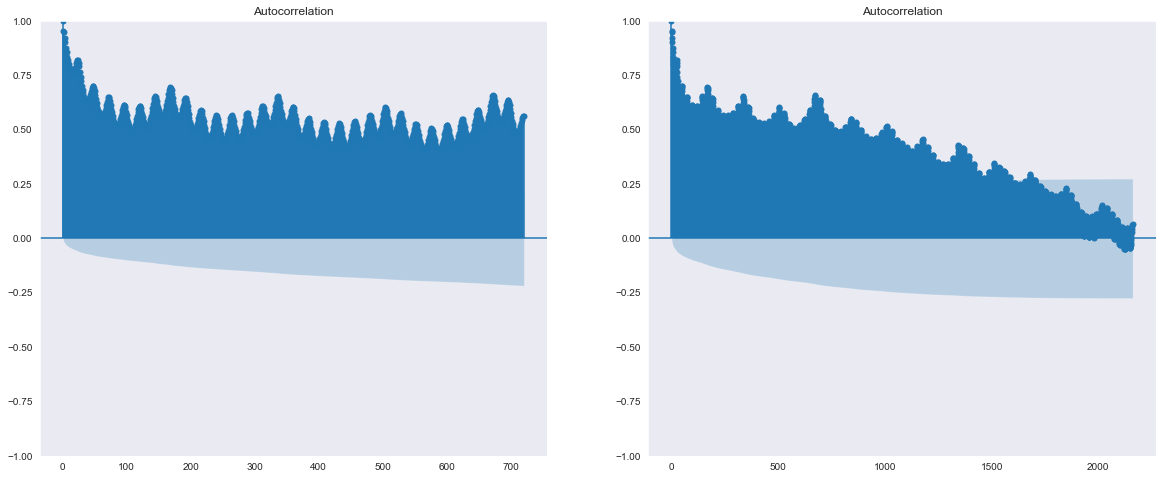

In [139]:
energy_demand_univar = demand_df['NES_demand_mwh']

fig, axs = plt.subplots(1,2, figsize=(20,8))

#we will plot the last 30 and 90 days
lags = [30*24, 90*24]

for ax, lag in zip(axs.flatten(), lags):
    plot_acf(energy_demand_univar, ax=ax, lags=lag)
plt.plot();

Our plots show clear autocorrelation between consecutive hours. Nearly every autoregressive feature is significant. This suggests a strong relationship between demand in previous hours and current demand. However, there's such strong correlations here that there's noise to filter when making predictions using this data. Selection of features seems difficult in this view.

Now, let's take a look at the plots corresponding to our hour-by-hour transformation. Remember, in this dataset, each hour is a separate feature. A lag-1 for the demand at a given hour points *not* to the previous hour, but to the last time demand was recorded at that hour - it represents a lag of one day.

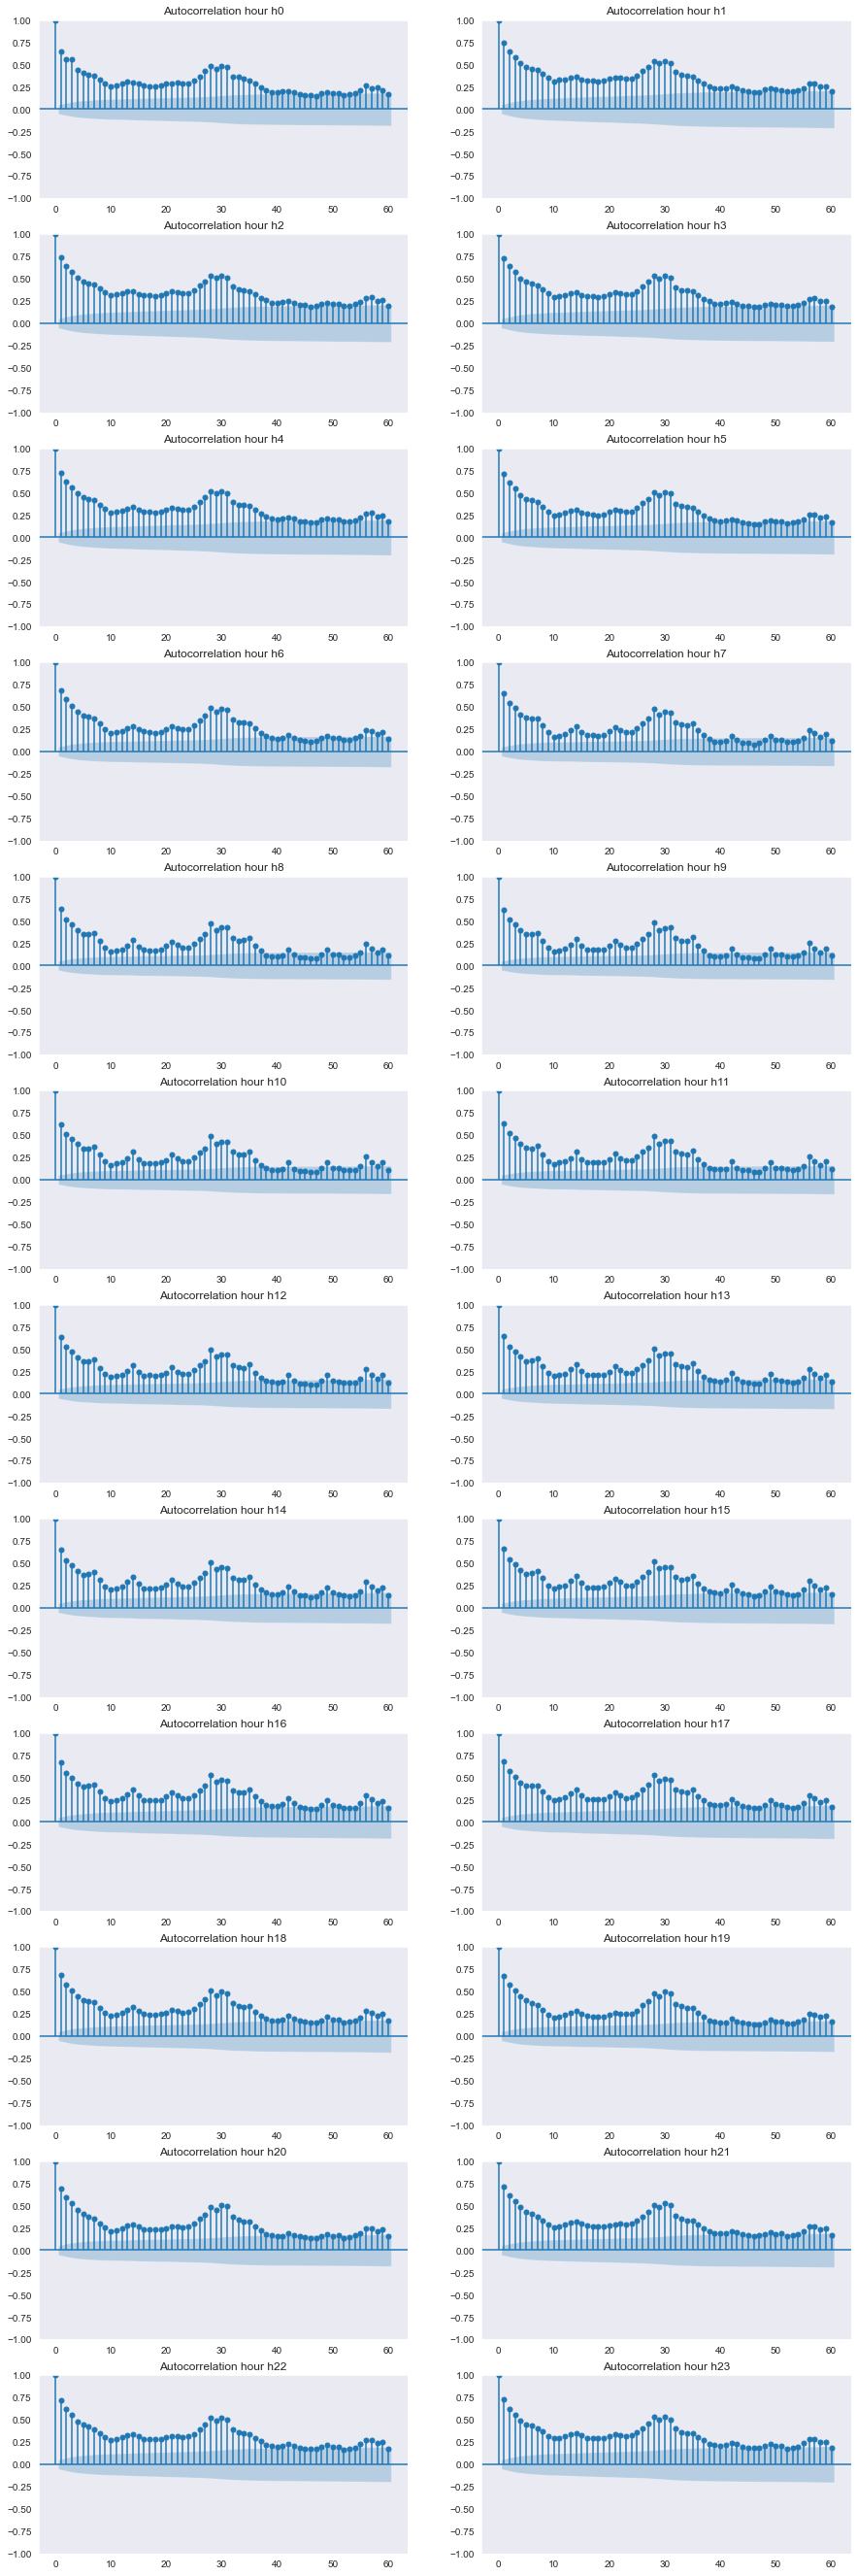

In [140]:
plots = len(demand_transform.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(demand_transform.columns, axs.flatten()):
        plot_acf(demand_transform.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Autocorrelation hour ' + str(hour))
plt.plot();

These results seem richer than the last and more informative. 

Generally speaking, demand at each hour of each day is highly correlated to the previous 30 or observations made at that hour. The first few days show the highest correlation to current demand values, 

There seems to be some kind of weekly pattern in autocorrelations for each hour. It's stronger in hours h6-h19 than the rest of the day.

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  w

[]

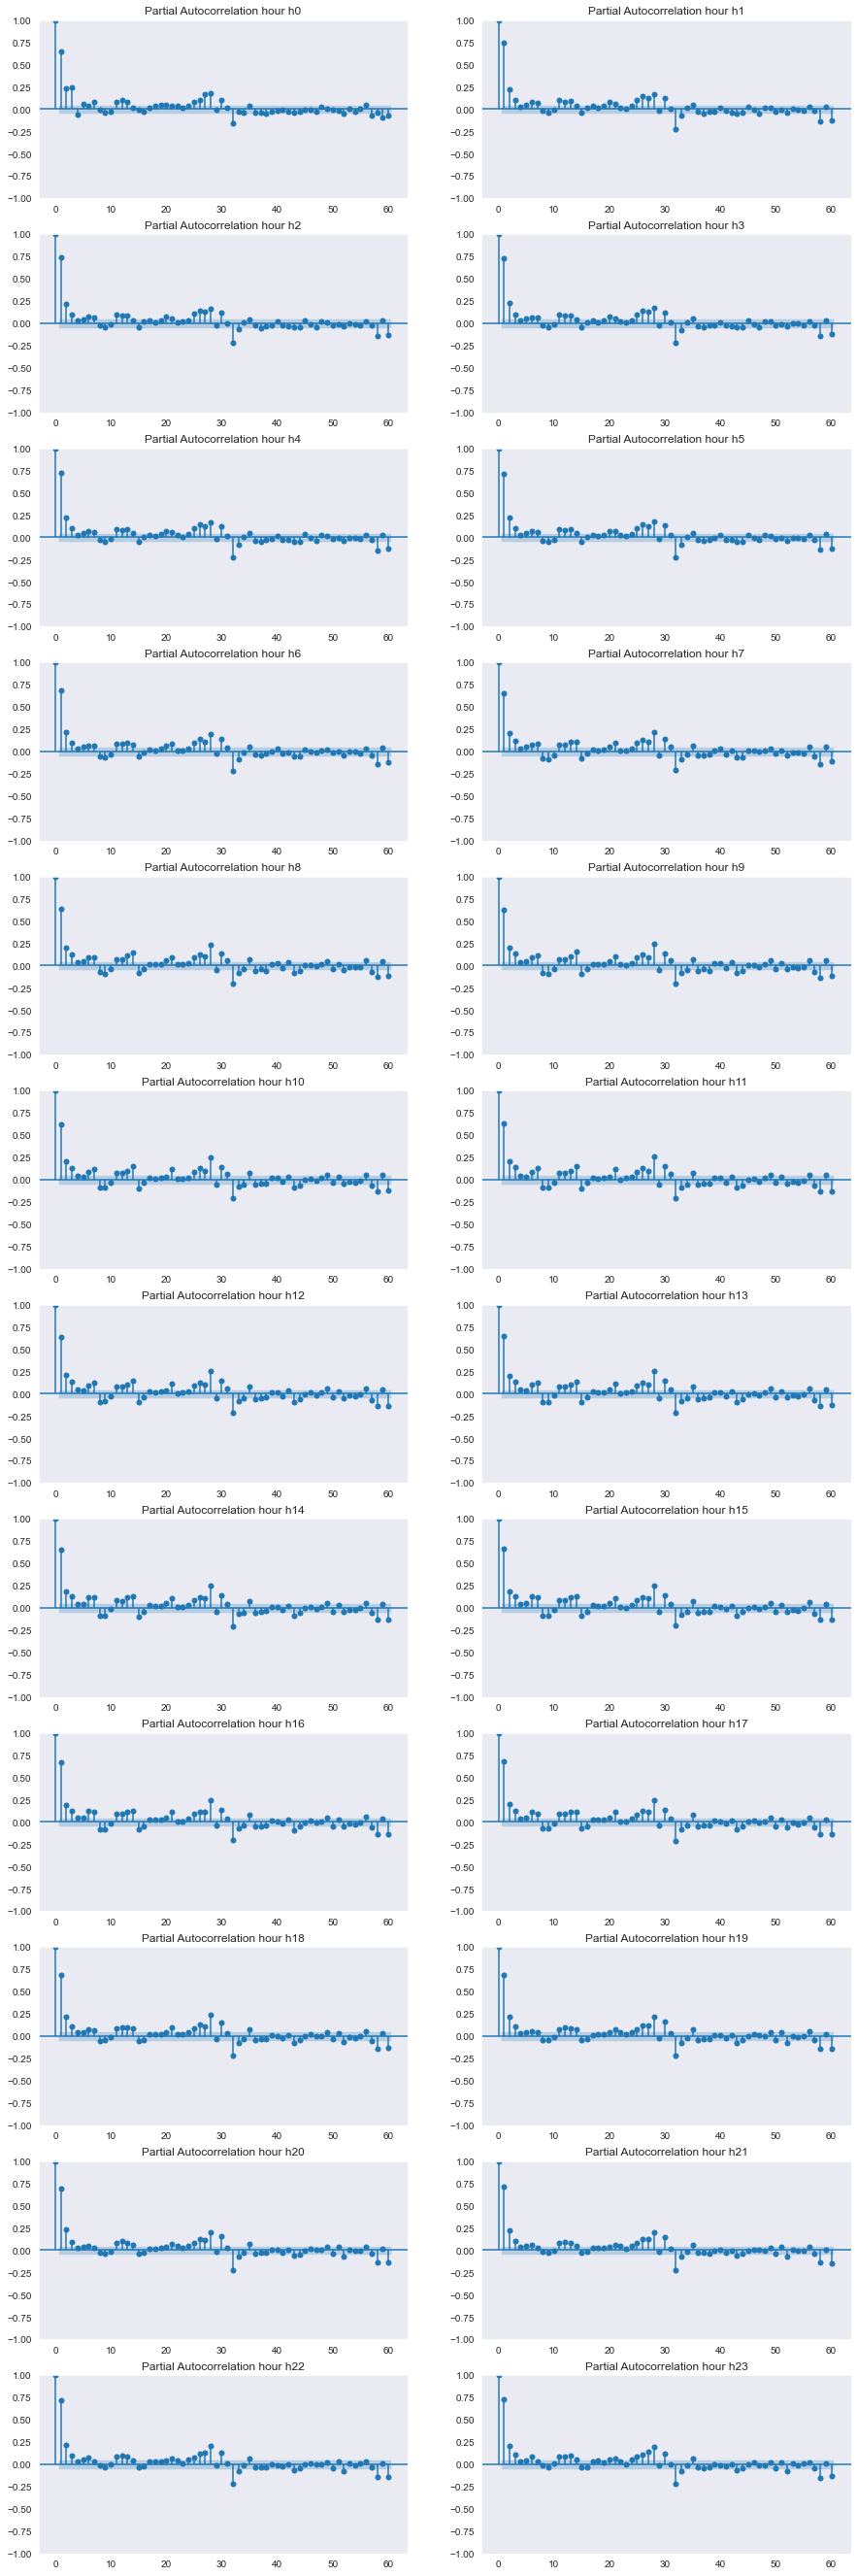

In [141]:
plots = len(demand_transform.columns)
fig, axs = plt.subplots(int(plots/2), 2, figsize=(15, 2*plots))

for hour, ax in zip(demand_transform.columns, axs.flatten()):
        plot_pacf(demand_transform.loc[:,hour], ax=ax, lags=60)
        ax.set_title('Partial Autocorrelation hour ' + str(hour))
plt.plot()

Compared to the first hourly sequential plots, the hour-by-hour partial autocorrelation plots drop off after the first couple of lags. They seem vaguely sinusoidial. This suggests there's a moving average process present.

## Building the Model

We will now get to building our LSTM model. First we will normalize our values using MinMaxScaler.
Afterwards, we will set up a supervised learning problem:
- X here will be composed of multiple days and columns for the hours of the day.
- Y here will be the 24 hours of observed energy demand for the target day.

The function split_sequences will return the target day as the Y value and will allow a combination of past days used in the prediction up to some maximum.

In [142]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)
    
    #return as dataframe
    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [143]:
#normalizing the demand dataframe
demand_normed, scaler = normalize_df(demand_transform)

In [144]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):

    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

In [145]:
#creating a supervised learning problem...
n_steps = 21

X, Y = split_sequences(demand_normed.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)
print(X.shape, Y.shape)
X[:5], Y[:5]

(1370, 26, 24) (1370, 24)


(array([[[0.12375096, 0.1190896 , 0.11821482, ..., 0.0765251 ,
          0.07583009, 0.07223641],
         [0.1179093 , 0.10947267, 0.10856294, ..., 0.07660232,
          0.08839366, 0.08099234],
         [0.10922367, 0.10450393, 0.10163339, ..., 0.07830116,
          0.08779539, 0.07931412],
         ...,
         [0.12797848, 0.13487738, 0.14015839, ..., 0.163861  ,
          0.16482202, 0.16001459],
         [0.15334358, 0.1485815 , 0.14997525, ..., 0.16030888,
          0.16078373, 0.16045239],
         [0.156495  , 0.15090559, 0.15525491, ..., 0.15559846,
          0.15554891, 0.15928493]],
 
        [[0.06625673, 0.06659721, 0.06657317, ..., 0.07474903,
          0.07388573, 0.07413353],
         [0.07517294, 0.06074691, 0.06690315, ..., 0.09042471,
          0.09392761, 0.08712149],
         [0.07209839, 0.0689213 , 0.0661607 , ..., 0.08216216,
          0.07919533, 0.07938709],
         ...,
         [0.15334358, 0.1485815 , 0.14997525, ..., 0.16030888,
          0.16078373, 0.

## Defining the LSTM Model

In [146]:
### Now that we've split X and Y, we now define the LSTM model

### The model will be created by a function that takes in the dimensions
### of a given DataGrame and prepares a LTSM neural network that expects
### those input dimensions and generates an output corresponding to the
### amount of hours (features) included in the input.


def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

## Defining a Crossvalidation Test Bench

In [147]:
## This function is going to provide us with the predictions of our LSTM model along with the 
## actual values of the series. The function will take in X and y, perform a time series split, and then leverage
## our LSTM model creation function to create and fit an LSTM model to the Training portion of the split data.
## It will then make predictions based on the Test portion of the split data.
## Finally, it will inverse transform both the predictions and the actual data for easy comparison.

def crossval_testbench(X, y, n_crossvals, epochs=5, verbose=0):

    n_hours = X.shape[-1]
    n_features = X.shape[1]
    
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X, y):
        
        #initalize the lstm model
        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
        #fit the model
        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)
        
        #make predictions
        predict = lstm_base.predict(X[test], verbose=verbose)


        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)
        
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    return predictions, actuals

In [148]:
preds, actuals = crossval_testbench(X, Y, 2, epochs=150, verbose=1)

Epoch 1/150


/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


15/15 [==============================] - 3s 11ms/step - loss: 0.1561
Epoch 2/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0820
Epoch 3/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0911
Epoch 4/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0873
Epoch 5/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0766
Epoch 6/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0684
Epoch 7/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0577
Epoch 8/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0536
Epoch 9/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0633
Epoch 10/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0545
Epoch 11/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0458
Epoch 12/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0522
Epoch 13/150
15/15 [=================

15/15 [==============================] - 0s 11ms/step - loss: 0.0382
Epoch 102/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0400
Epoch 103/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0382
Epoch 104/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0380
Epoch 105/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 106/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0375
Epoch 107/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0351
Epoch 108/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0375
Epoch 109/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0395
Epoch 110/150
15/15 [==============================] - 0s 12ms/step - loss: 0.0411
Epoch 111/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0399
Epoch 112/150
15/15 [==============================] - 0s 11ms/step - loss: 0.0373
Epoch 113/150
15/1

/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


29/29 [==============================] - 3s 11ms/step - loss: 0.1391
Epoch 2/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0808
Epoch 3/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0768
Epoch 4/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0691
Epoch 5/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0645
Epoch 6/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0643
Epoch 7/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0626
Epoch 8/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0596
Epoch 9/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0576
Epoch 10/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0561
Epoch 11/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0538
Epoch 12/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0569
Epoch 13/150
29/29 [=================

29/29 [==============================] - 0s 12ms/step - loss: 0.0440
Epoch 102/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0454
Epoch 103/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0427
Epoch 104/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0439
Epoch 105/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0446
Epoch 106/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0440
Epoch 107/150
29/29 [==============================] - 0s 11ms/step - loss: 0.0424
Epoch 108/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0440
Epoch 109/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0425
Epoch 110/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 111/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0437
Epoch 112/150
29/29 [==============================] - 0s 12ms/step - loss: 0.0445
Epoch 113/150
29/2

In [149]:
preds.shape, actuals.shape

((2, 456, 24), (2, 456, 24))

## Reviewing Model Performance

Here wil will calculate and plot Mean Absolute Percentage Error (MAPE) for each hourly prediction.

In [150]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [151]:
#MAPE for a specific hour
error_h0 = mean_absolute_percentage_error(actuals[0,:5,0], preds[0, :5,0])
print(f'MAPE for Hour 0: {round(error_h0, 2)}')


MAPE for Hour 0: 6.44


In [152]:
crossvals = actuals.shape[0]
hours = actuals.shape[2]

errors_crossvals = list()
for crossval in range(crossvals):
    errors_hourly = [mean_absolute_percentage_error(actuals[crossval, :, hour], preds[crossval, :, hour]) for hour in range(hours)]
    errors_crossvals.append(errors_hourly)
    
errors = pd.DataFrame(errors_crossvals)
errors['mean'] = errors.mean(axis=1)
errors.index.name='crossval set'
errors.columns.name='hours'
errors

hours                 0         1         2         3         4         5         6         7          8          9         10         11         12         13         14         15         16         17         18        19        20        21         22         23       mean
crossval set                                                                                                                                                                                                                                                                         
0             10.875316  9.478406  9.137530  9.294894  8.804039  8.475734  8.280505  8.960268  10.899161  10.688395  10.364768  10.375641  10.746142  11.031446  11.625148  11.917583  11.900777  11.333438  10.201517  9.216480  9.238457  9.936103  10.803627  11.430776  10.209006
1              9.075549  8.554030  8.494562  8.399948  8.247738  8.133490  8.358693  9.255879   9.866983  10.076347  10.078450  10.049291  10.053947  10.292820  10.673588  10.951864  10.778953  10.280726   9.332510  9.062525  8.982103  9.308454   9.989224  10.496018   9.533071

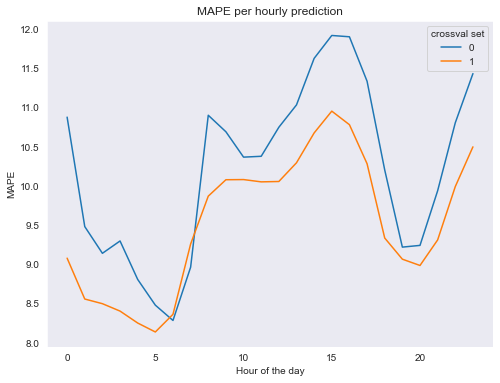

In [153]:
plt.figure(figsize=(8,6))
plt.plot(errors.drop(columns='mean').T)
plt.title('MAPE per hourly prediction')
plt.legend(errors.index, title='crossval set')
plt.xlabel('Hour of the day')
plt.ylabel('MAPE')
plt.show()

It seems that MAPE tends to track at around 7 to as high as 11%, which is just not an amazing range for demand predictions. We want to avoid black-outs and brown outs.

## Predicting on an Unseen Test Set

Here we'll see how our LSTM model would do against a totally unseen test set. What we'll do here is that we'll build an LSTM model that is trained on data from 2019-2021 inclusive, and then see how our predictions do for the year 2022.

In [154]:
## Here we use a function to split our data according to a clean start and end date.

def train_test_split(df, split_date):
    
    
    train_date = pd.Timestamp(split_date).strftime('%Y-%m-%d')
    test_date = (pd.Timestamp(split_date) + timedelta(1)).strftime('%Y-%m-%d')
    
    df_train = df[:train_date]
    df_test = df[test_date:]
    
    return df_train, df_test

train, test = train_test_split(demand_transform, '2021-12-31')

print(f'Training start date {train.index.min()} end date {train.index.max()}')
print(f'Training start date {test.index.min()} end date {test.index.max()}')


Training start date 2019-01-01 00:00:00 end date 2021-12-31 00:00:00
Training start date 2022-01-01 00:00:00 end date 2022-12-31 00:00:00


In [155]:
## Normalizing our data before modeling, making sure test and train are in compatible shapes

train_norm, scalar = normalize_df(train)
test_norm = scalar.transform(test)

#create the supervised learning problem
n_steps = 21

X_train, Y_train = split_sequences(train_norm.values, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Training Set X {X_train.shape} and Y {Y_train.shape}')

Training Set X (1025, 26, 24) and Y (1025, 24)


/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [156]:
test_set = np.vstack([train_norm.values[-60:], test_norm])
print(f'Dimensions of the test set with training data needed for predictions: {test_set.shape}')

X_test, Y_test = split_sequences(test_set, n_steps, extra_lag=True, long_lag_step=7, max_step=60, idx=0, multivar=False)

print(f'Testing Set X {X_test.shape} and Y {Y_test.shape}')

Dimensions of the test set with training data needed for predictions: (405, 24)
Testing Set X (345, 26, 24) and Y (345, 24)


In [157]:
n_features=X_train.shape[1]
n_hours=X_train.shape[2]
#initalize the lstm model
lstm_eval = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
#fit the model
lstm_eval.fit(X_train, Y_train, epochs=350, verbose=1, shuffle=False)
        
#check predictions on the train set
train_predictions = lstm_eval.predict(X_train, verbose=1)

#run predictions on test data
test_predictions = lstm_eval.predict(X_test, verbose=1)

Epoch 1/350


/Users/ricardoalatorre/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


33/33 [==============================] - 3s 11ms/step - loss: 0.1297
Epoch 2/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0770
Epoch 3/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0609
Epoch 4/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0606
Epoch 5/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0568
Epoch 6/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0568
Epoch 7/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0580
Epoch 8/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0559
Epoch 9/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 10/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0525
Epoch 11/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0517
Epoch 12/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0523
Epoch 13/350
33/33 [=================

33/33 [==============================] - 0s 12ms/step - loss: 0.0424
Epoch 102/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0404
Epoch 103/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0418
Epoch 104/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0404
Epoch 105/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0411
Epoch 106/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0442
Epoch 107/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0414
Epoch 108/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0407
Epoch 109/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0417
Epoch 110/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0444
Epoch 111/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0411
Epoch 112/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0392
Epoch 113/350
33/3

33/33 [==============================] - 0s 11ms/step - loss: 0.0404
Epoch 200/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0397
Epoch 201/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0398
Epoch 202/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0376
Epoch 203/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0385
Epoch 204/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0401
Epoch 205/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0396
Epoch 206/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0401
Epoch 207/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0409
Epoch 208/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0404
Epoch 209/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0400
Epoch 210/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0388
Epoch 211/350
33/3

33/33 [==============================] - 0s 12ms/step - loss: 0.0390
Epoch 298/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0378
Epoch 299/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0377
Epoch 300/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0392
Epoch 301/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0380
Epoch 302/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0391
Epoch 303/350
33/33 [==============================] - 0s 13ms/step - loss: 0.0379
Epoch 304/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0377
Epoch 305/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0385
Epoch 306/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 307/350
33/33 [==============================] - 0s 11ms/step - loss: 0.0408
Epoch 308/350
33/33 [==============================] - 0s 12ms/step - loss: 0.0383
Epoch 309/350
33/3

## Rescaling Predictions & Evaluating

As we did earlier, we  have to inverse transform our predictions in order to get a better look at them and see by how much off the mark we were in Mean Absolute Percentage terms.

In [158]:
train_preds = scalar.inverse_transform(train_predictions)
test_preds = scalar.inverse_transform(test_predictions)
Y_train = scalar.inverse_transform(Y_train)
Y_test = scalar.inverse_transform(Y_test)

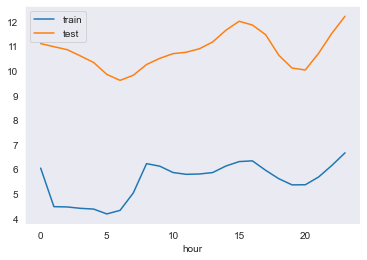

In [159]:
train_error = pd.DataFrame([mean_absolute_percentage_error(Y_train[:, hour], train_preds[:, hour]) for hour in range(hours)], columns=['train'])
test_error = pd.DataFrame([mean_absolute_percentage_error(Y_test[:, hour], test_preds[:, hour]) for hour in range(hours)], columns=['test'])

errors = pd.concat([train_error, test_error], axis=1)
errors.index.name = 'hour'
errors.plot();

Seems our MAPE scores were better on the Train set than the Test set. We may have overfit a bit.

## Plot Holdout Test Predictions

Now we're going to take a more direct look at how our actual demand, predicted demand, and government-predicted demand stacked up against each other.

In [160]:
test_df = pd.DataFrame(test_preds).stack()
Y_test_df = pd.DataFrame(Y_test).stack()

preds_df = pd.concat([Y_test_df, test_df], axis=1)
preds_df.columns = ['actual', 'predicted']

In [161]:
## Here we limit our scope to 2022, and re-create a datetime index.

preds_df.index = preds_df.index.set_levels(demand_transform[pd.to_datetime(demand_transform.index).year == 2022].index, level=0)
preds_df.reset_index(inplace=True)
preds_df['year'] = preds_df['level_0'].dt.year
preds_df['month'] = preds_df['level_0'].dt.month
preds_df['day'] = preds_df['level_0'].dt.day
preds_df['hour'] = preds_df['level_1']
preds_df['date_and_time'] = pd.to_datetime(preds_df[['year', 'month', 'day', 'hour']])
preds_df.drop(columns=['level_0', 'level_1', 'year', 'month', 'day', 'hour'], inplace=True)
preds_df.set_index('date_and_time', inplace=True)

In [162]:
preds_df

actual    predicted
date_and_time                           
2022-01-01 00:00:00  4152.0  5017.367676
2022-01-01 01:00:00  4119.0  4813.350586
2022-01-01 02:00:00  4034.0  4720.991211
2022-01-01 03:00:00  3967.0  4689.886719
2022-01-01 04:00:00  3803.0  4696.774414
...                     ...          ...
2022-12-31 19:00:00  4545.0  5550.243164
2022-12-31 20:00:00  4344.0  5538.917969
2022-12-31 21:00:00  4225.0  5438.256348
2022-12-31 22:00:00  4054.0  5301.383301
2022-12-31 23:00:00  3955.0  5219.693848

[8280 rows x 2 columns]

In [163]:
# Here we salvage the CENACE's own predictions to compare against our own
gov_preds = demand_df[pd.to_datetime(demand_df.index).year==2022]
gov_preds.index = pd.to_datetime(gov_preds.index)
preds_df = preds_df.join(gov_preds, how='inner').drop(columns=['NES_demand_mwh'])
preds_df.columns = ['actual', 'predicted', 'gov_predicted']

In [164]:
preds_df

actual    predicted  gov_predicted
date_and_time                                          
2022-01-01 00:00:00  4152.0  5017.367676           3956
2022-01-01 01:00:00  4119.0  4813.350586           3899
2022-01-01 02:00:00  4034.0  4720.991211           3806
2022-01-01 03:00:00  3967.0  4689.886719           3726
2022-01-01 04:00:00  3803.0  4696.774414           3650
...                     ...          ...            ...
2022-12-31 19:00:00  4545.0  5550.243164           4437
2022-12-31 20:00:00  4344.0  5538.917969           4248
2022-12-31 21:00:00  4225.0  5438.256348           4108
2022-12-31 22:00:00  4054.0  5301.383301           4028
2022-12-31 23:00:00  3955.0  5219.693848           3922

[8758 rows x 3 columns]

<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-165-33425f98c9c5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

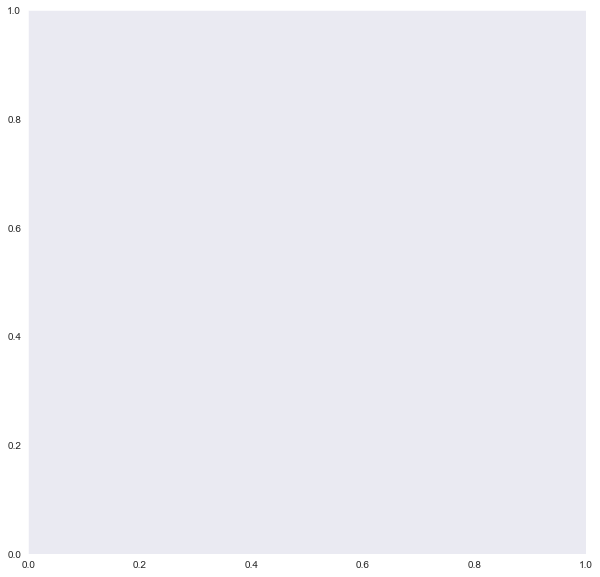

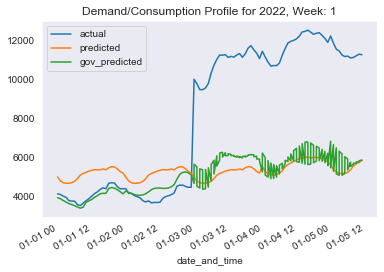

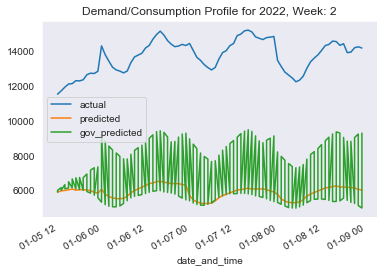

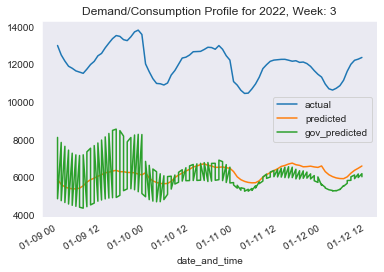

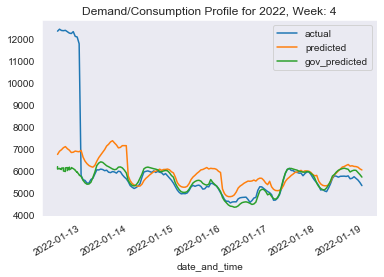

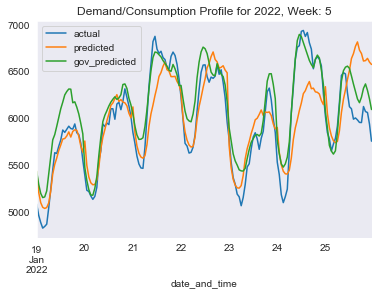

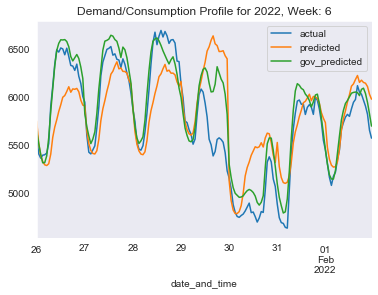

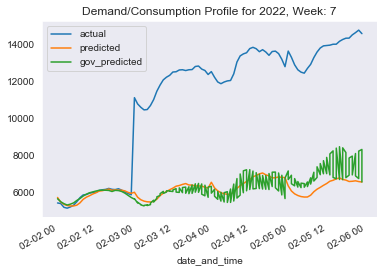

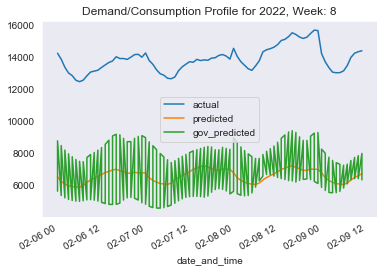

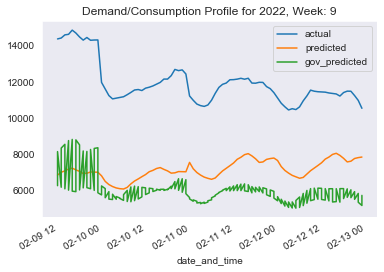

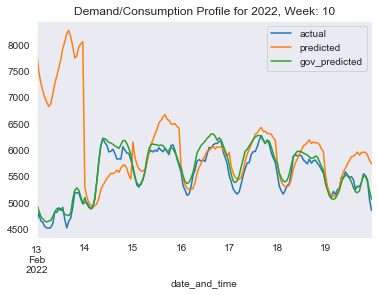

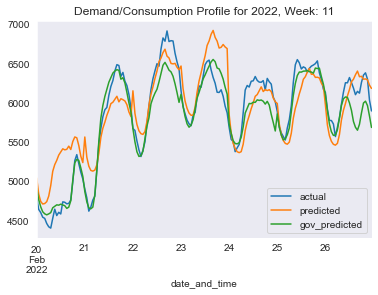

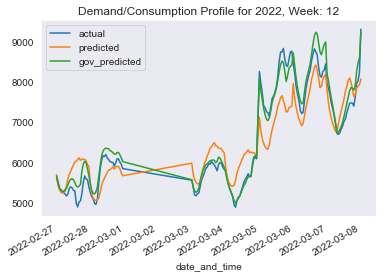

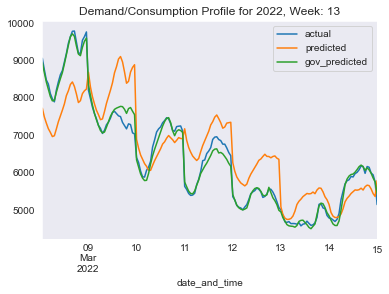

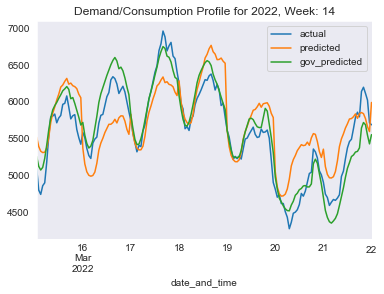

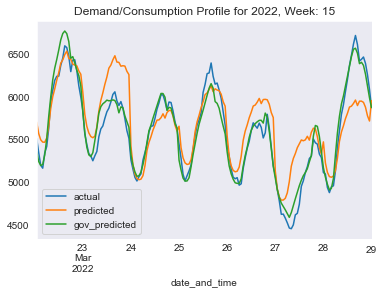

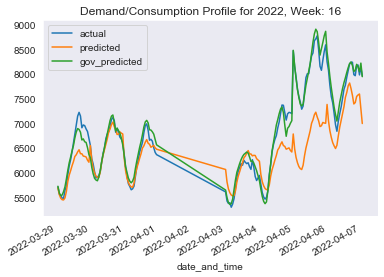

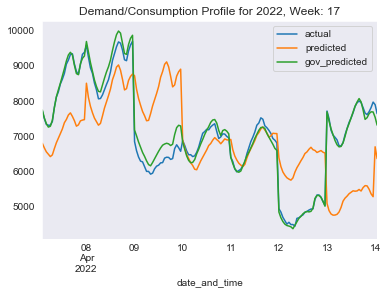

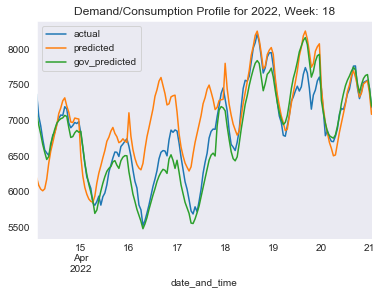

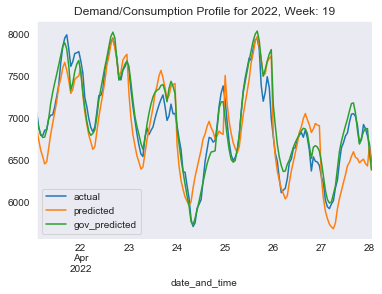

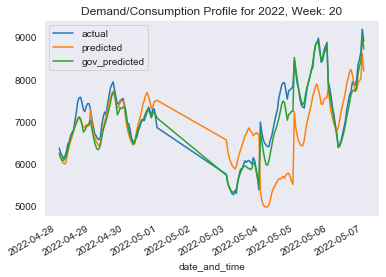

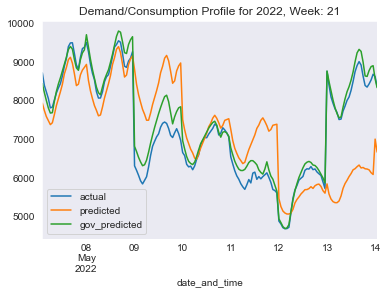

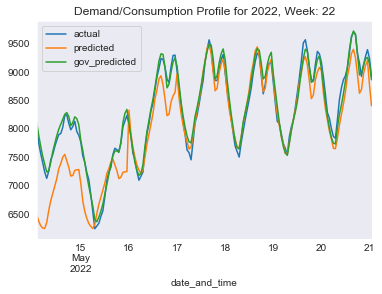

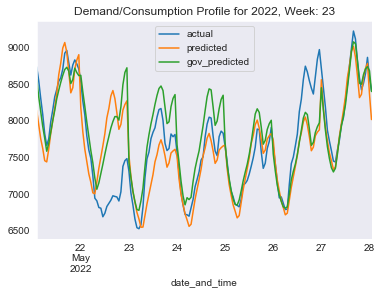

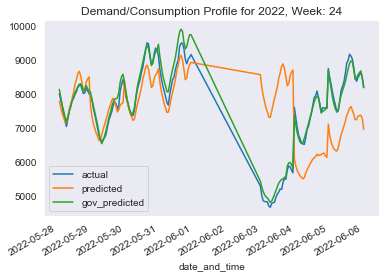

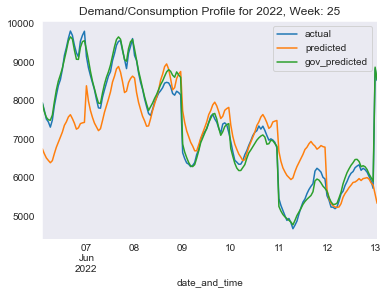

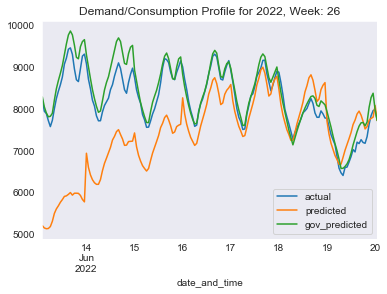

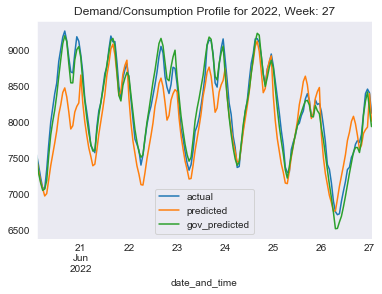

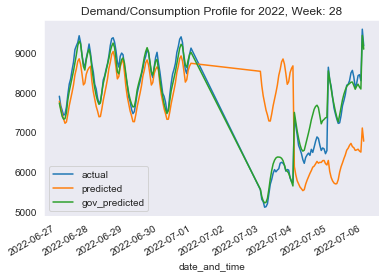

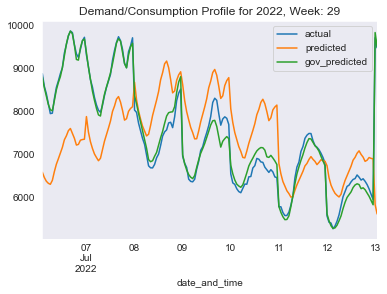

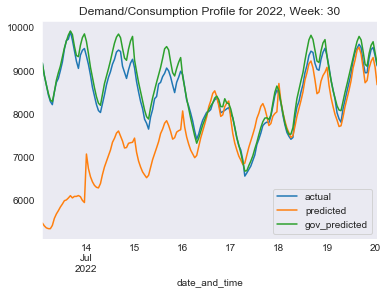

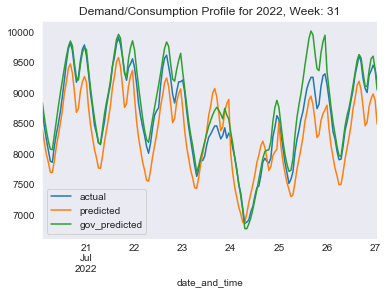

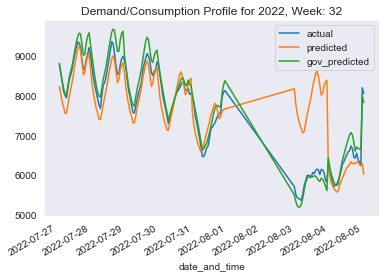

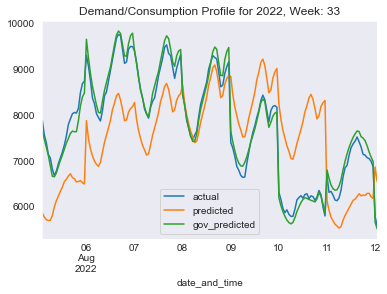

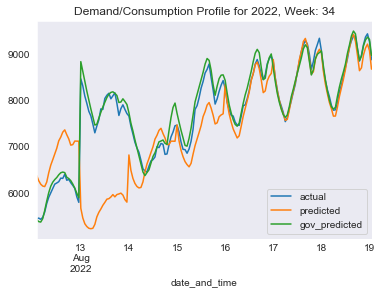

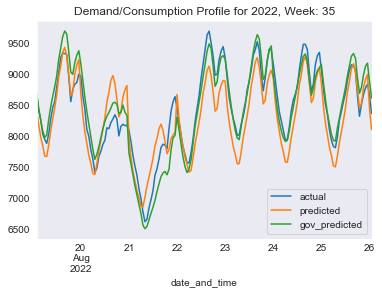

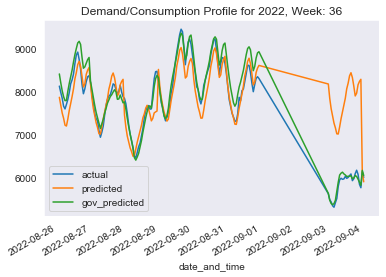

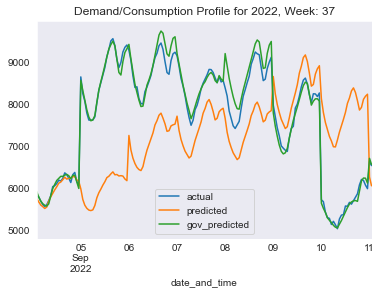

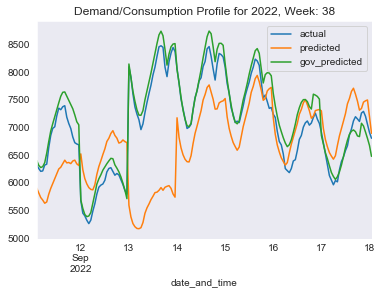

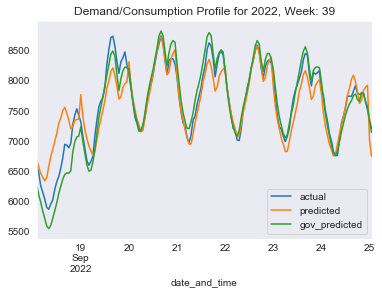

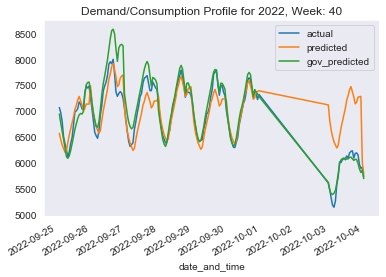

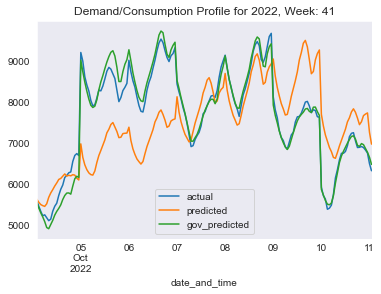

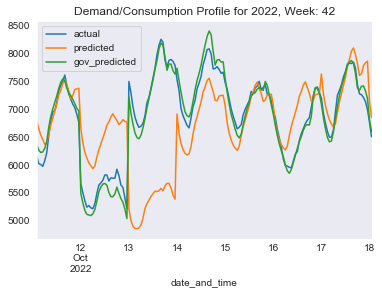

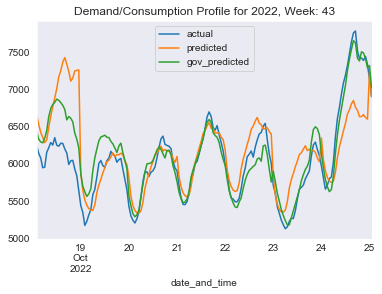

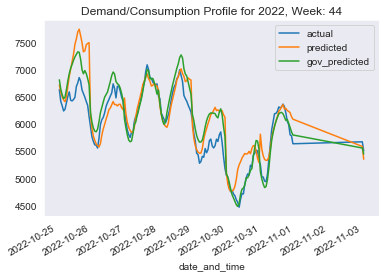

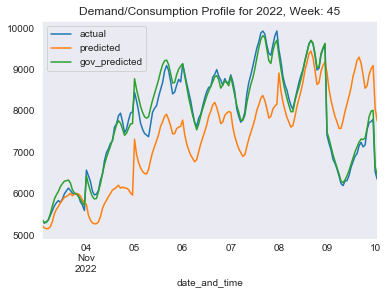

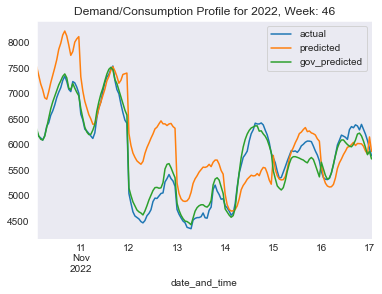

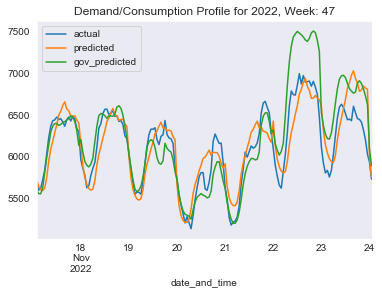

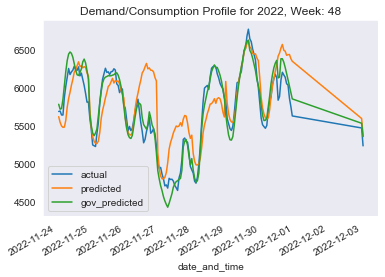

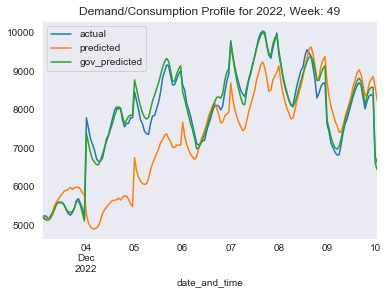

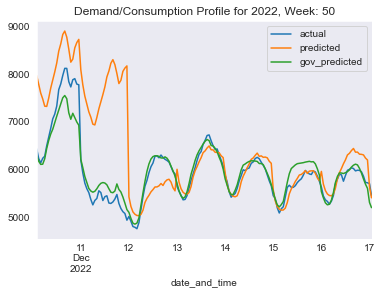

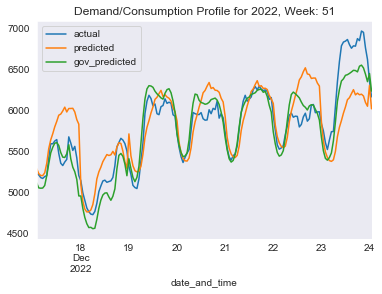

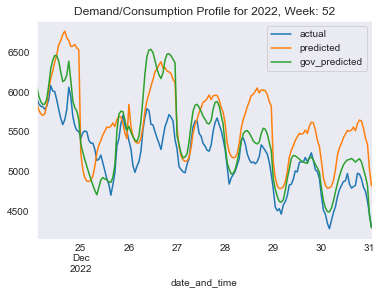

In [165]:
fig = plt.figure(figsize=(10,10))

for week in range(52):

    fig.add_subplot()
    preds_df.iloc[week*7*24:(week+1)*7* 24].plot()
    plt.title(f'Demand/Consumption Profile for 2022, Week: {week+1}')


It seems our demand predictions are often similar to those of the government, but these series occasionally diverge wildly, with the government prediction being more right than not.

Let's compare MAPE scores as well.

In [166]:
preds_df['pred_MAPE'] = ((preds_df['actual'] - preds_df['predicted'])/(preds_df['actual'])).abs() * 100
preds_df['gov_MAPE'] = ((preds_df['actual'] - preds_df['gov_predicted'])/(preds_df['actual'])).abs() * 100

<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot()
<ipython-input-167-38a8825d03b6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

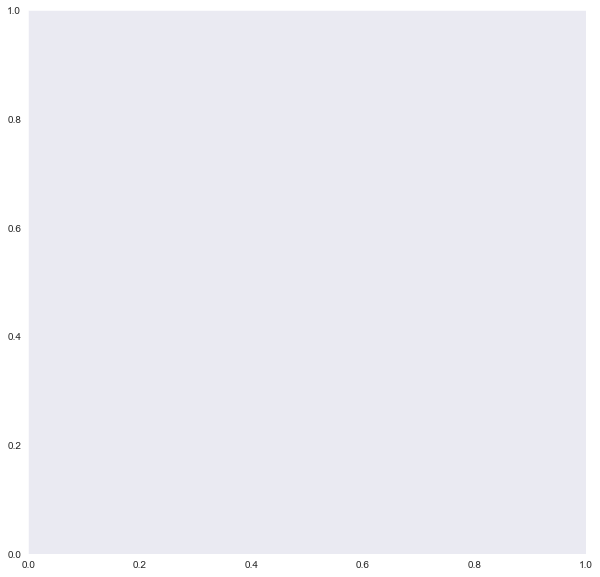

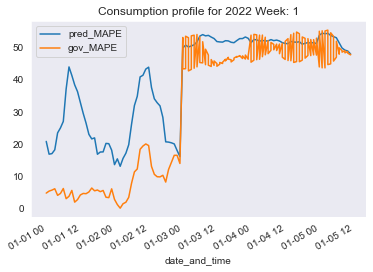

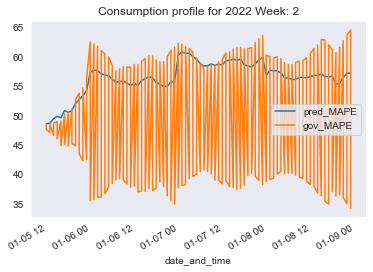

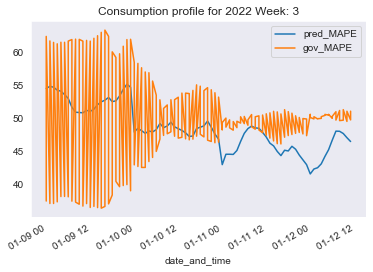

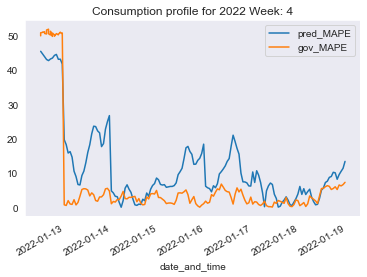

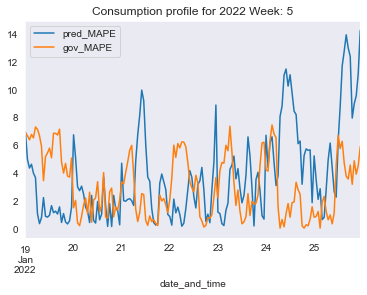

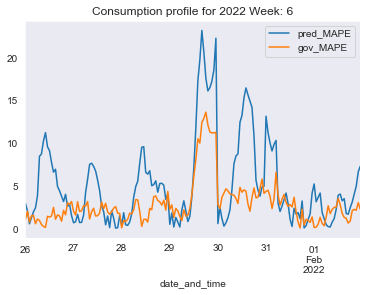

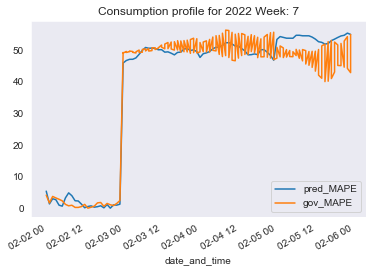

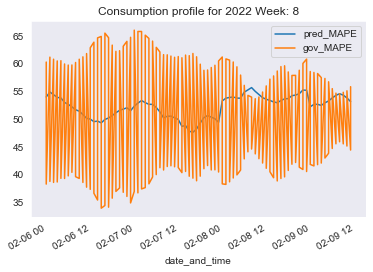

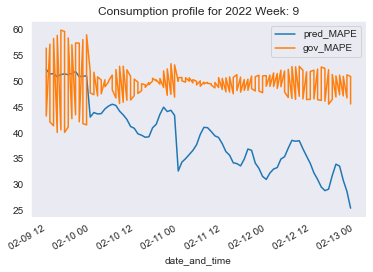

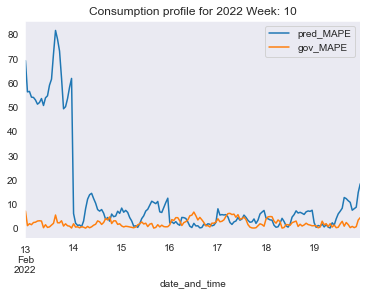

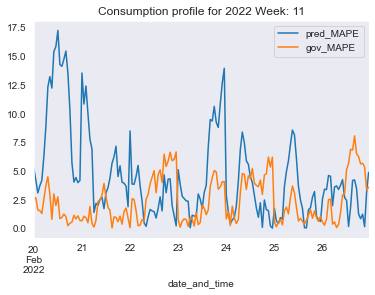

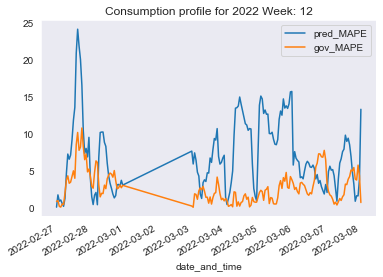

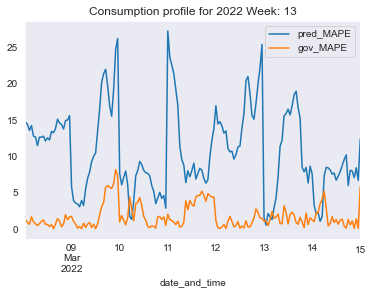

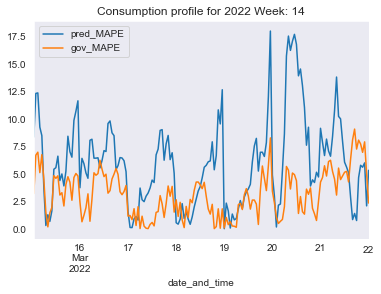

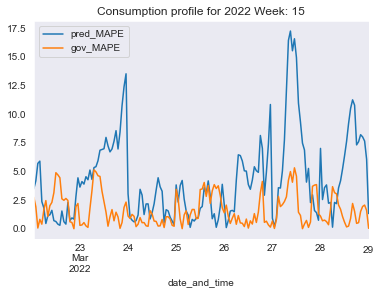

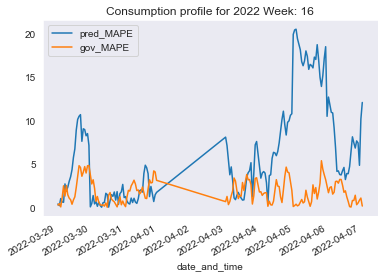

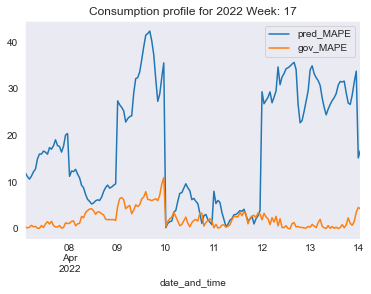

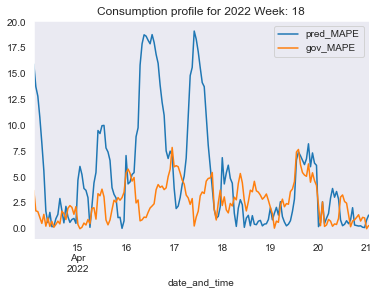

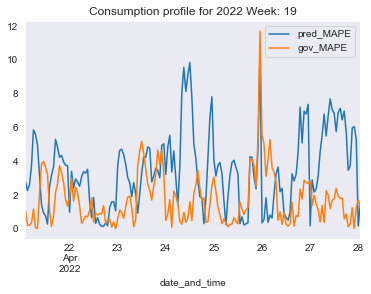

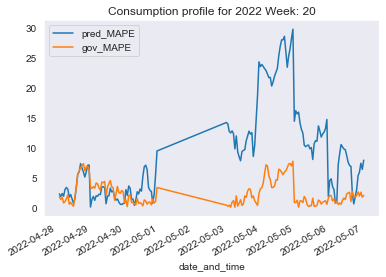

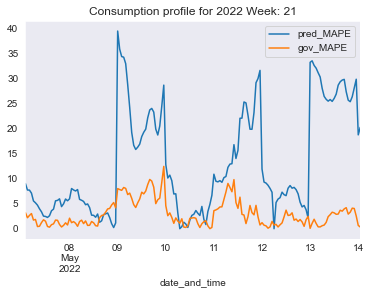

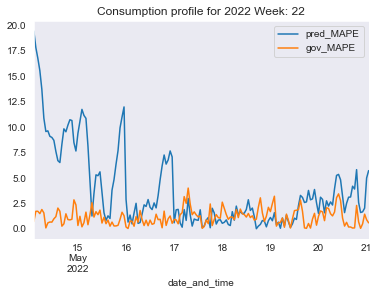

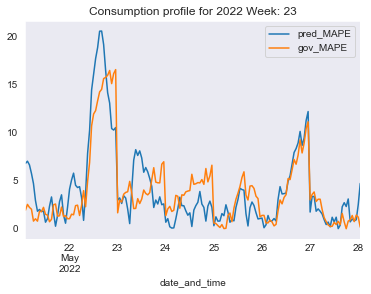

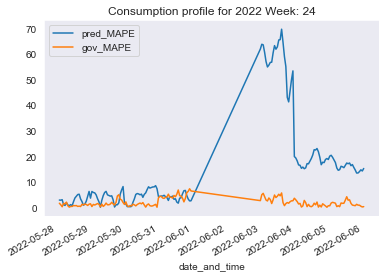

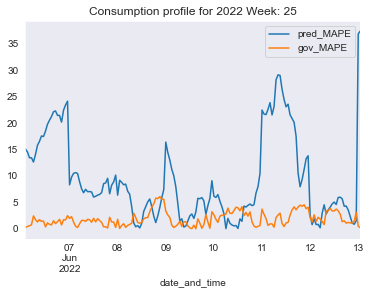

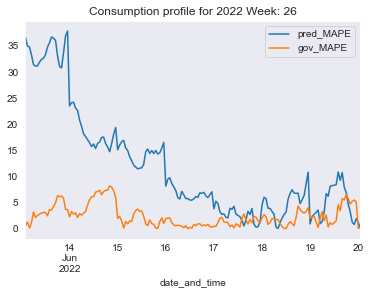

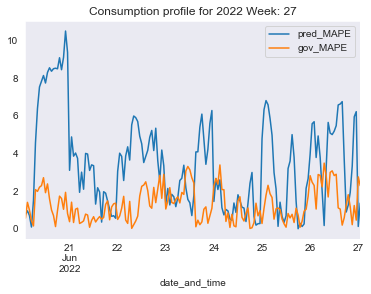

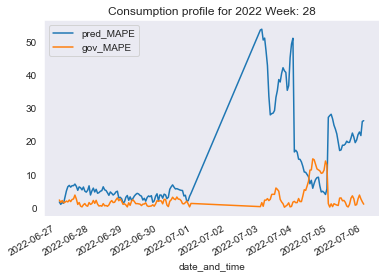

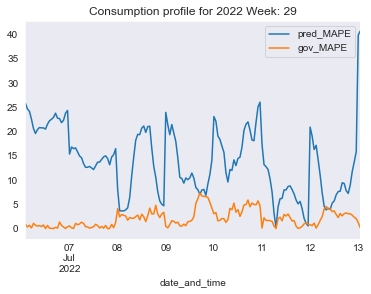

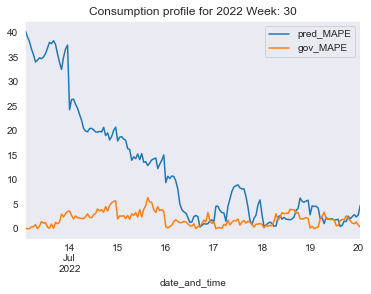

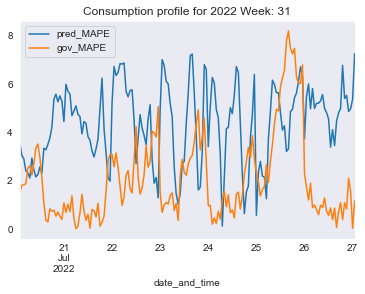

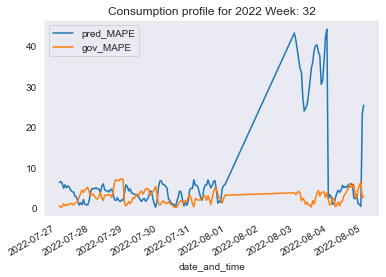

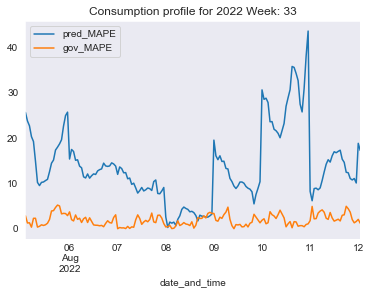

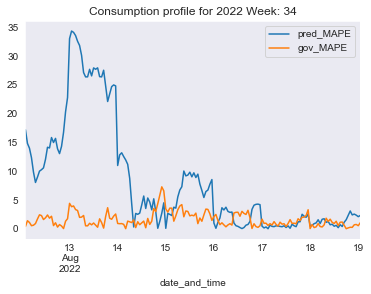

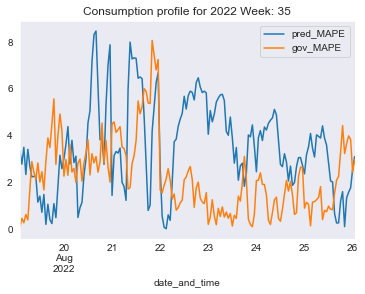

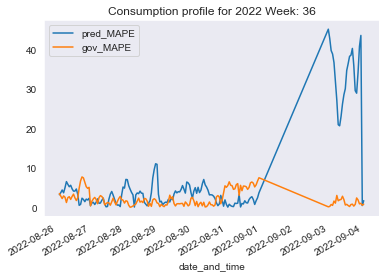

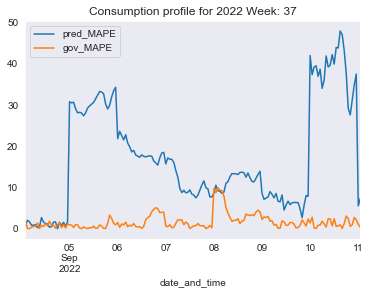

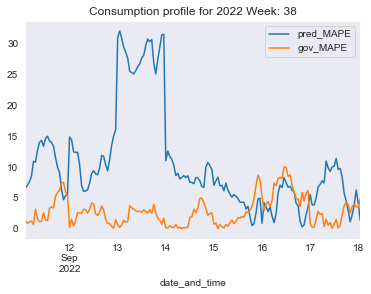

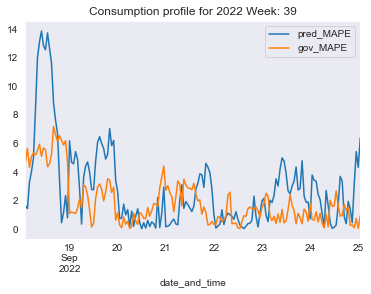

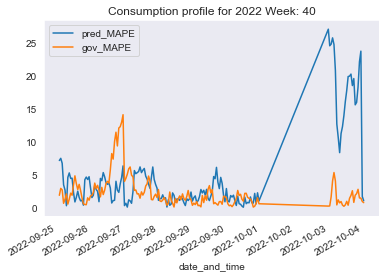

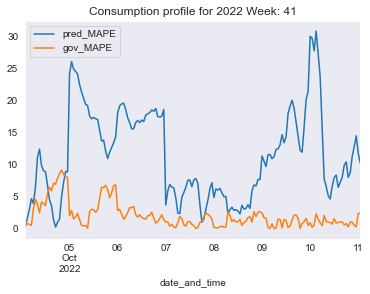

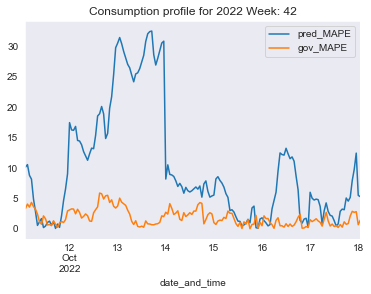

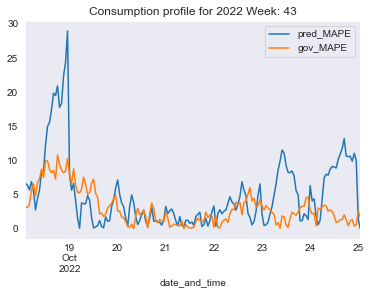

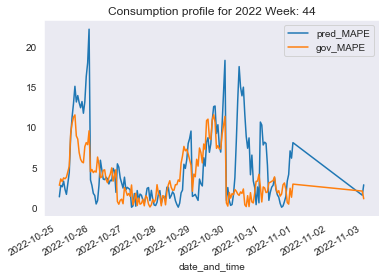

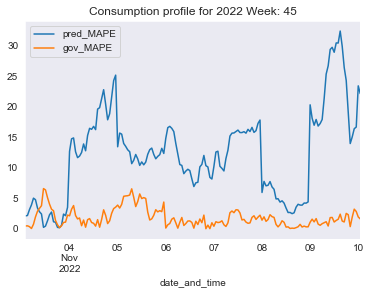

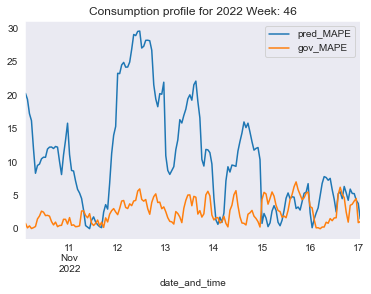

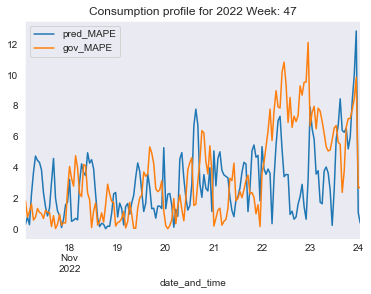

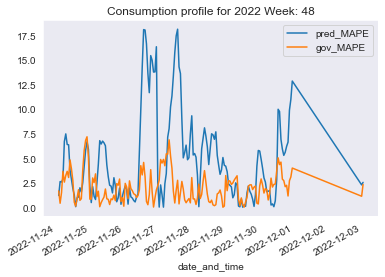

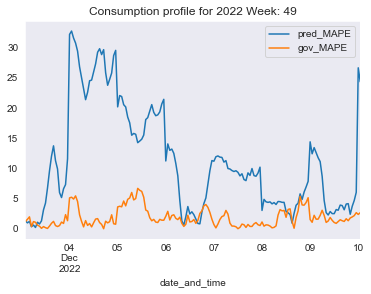

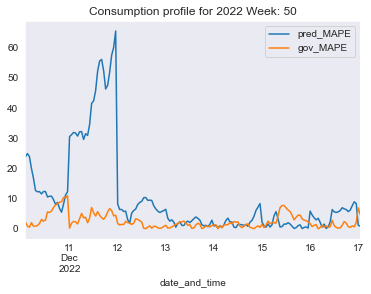

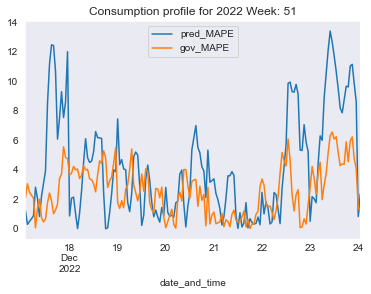

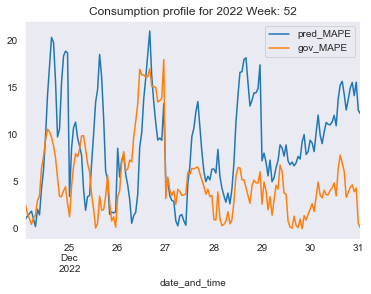

In [167]:
fig = plt.figure(figsize=(10,10))

for week in range(52):

    fig.add_subplot()
    preds_df[['pred_MAPE', 'gov_MAPE']].iloc[week*7*24:(week+1)*7* 24].plot()
    plt.title(f'Consumption profile for 2022 Week: {week+1}')

As in the demand prediction themselves, it seems that our MAPE scores trail the government's somewhat, with many weeks showing a huge discrepancy. Let's see what happens on average.

In [168]:
preds_df['pred_MAPE'].mean()

12.93821990392841

In [169]:
preds_df['gov_MAPE'].mean()

7.584673783714597

## Conclusions: LTSM Model Forecast

It seems that a univariate LTSM forecast does a reasonably good job of predicting energy demand. However, this 'reasonably good' is not up to the standards of the government's own energy demand predictions, which have a average MAPE of roughly 7.6%, compared to our own 13%. However, notice that we got this close by merely using historical real demand data. How much might we reduce the MAPE if we included other time series, such as weather data?

Also, note that for some weeks, it really does seem like our LTSM gives the government predictions a run for their money (see Week 39, for example.)